In [1]:
%%javascript 
IPython.OutputArea.prototype._should_scroll = function(lines) { return false; }

<IPython.core.display.Javascript object>

## Visualisation of Areas of Interest

In [15]:
import pandas as pd 
import matplotlib.pyplot as plt

uji_data = pd.read_csv('Data\\AllData.csv')
dbscan_centroids = pd.read_csv('Outputs\\4\\dbscan_centroids.csv')
edr_trajectories = json.loads(open('Outputs\\3\\edr_clusters.txt').read())

# floorplan for visualisation
floorplan = plt.imread("Data\\UJI_B012_floorplan.png")

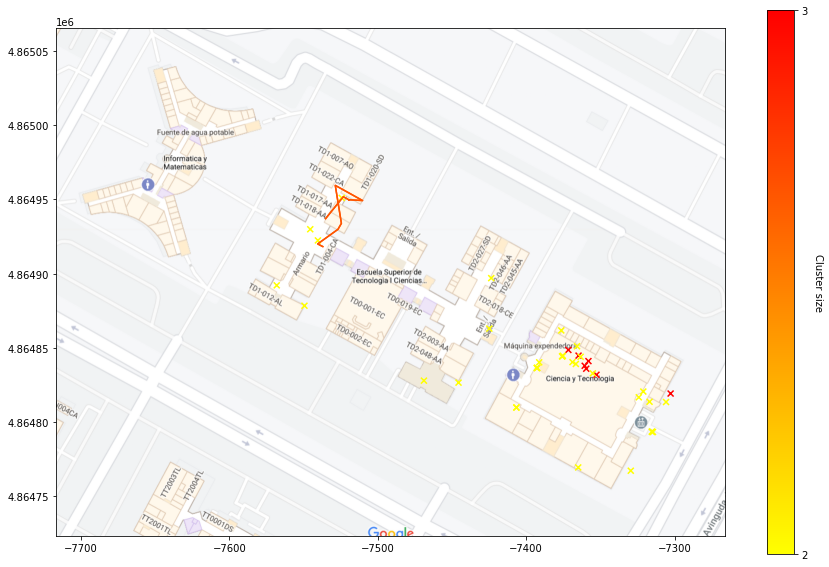

In [30]:
from matplotlib import cm

x_left, y_bottom = -7717, 4864723
width, height = floorplan.shape[1], floorplan.shape[0]
scale = 0.40

plt.figure(figsize=(15,10))
plt.axes().set_aspect('equal', 'box')
plt.imshow(floorplan, extent=[x_left, x_left + scale*width, y_bottom, y_bottom + scale*height])
plt.scatter(dbscan_centroids['LONGITUDE'], dbscan_centroids['LATITUDE'], c=dbscan_centroids['pts_count'], cmap='autumn_r', marker='x')

cmap = cm.get_cmap('autumn_r')
for i in range(len(edr_trajectories)):
    c = edr_trajectories[i]
    rgba = cmap(len(c)/dbscan_centroids['pts_count'].max())
    
    for j in range(len(c)):
        sequence = c[j]
        
        lat = [x[1] for x in sequence]
        long = [x[2] for x in sequence]
        plt.plot(long, lat, color=rgba[:3])

# Color bar legend
cbar = plt.colorbar()
cbar.ax.get_yaxis().set_ticks([i for i in range(2, dbscan_centroids['pts_count'].max()+1)])
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Cluster size', rotation=270)

plt.show()

## Optimise the Scheduling of Users Access to Site 

In [2]:
from ortools.sat.python import cp_model
from itertools import combinations
import math
from sklearn import preprocessing


def solve_day_scheduling(users_count, num_days, cmc_adj_mat, cluster_adj_mat):
    # Normalize cmc_adj_mat and cluster_adj_mat
    scaler = preprocessing.MinMaxScaler()
    cmc_adj_mat = scaler.fit_transform(cmc_adj_mat)
    cluster_adj_mat = scaler.fit_transform(cluster_adj_mat)
    cmc_adj_mat = np.floor(cmc_adj_mat * 1000).astype(int)
    cluster_adj_mat = np.floor(cluster_adj_mat * 1000).astype(int)

    model = cp_model.CpModel()

    allowed = {}
    for u in range(users_count):
        for d in range(num_days):
            allowed[u, d] = model.NewBoolVar('allowed_user%ion%i' % (u, d))

    # only allow 70% of all users each day
    for d in range(num_days):
        model.Add(sum(allowed[u, d] for u in range(users_count)) <= math.floor(users_count * 0.7))

    # allow each user for 3 days in a week
    for u in range(users_count):
        model.Add(sum(allowed[u, d] for d in range(num_days)) == 3)

    max_bool_vars = []
    max_bool_coeffs = []
    min_bool_vars = []
    min_bool_coeffs = []

    for d in range(num_days):
        for pair in list(combinations([x for x in range(users_count)], 2)):
            # if both 1 then award with edge weight in cmc_adj_mat
            # to encourage closely connected users to be allowed on same day
            same_day_var = model.NewBoolVar('%i and %i same on day %i' % (pair[0], pair[1], d))
            model.AddBoolOr([allowed[pair[0], d].Not(),
                             allowed[pair[1], d].Not(),
                             same_day_var])
            max_bool_vars.append(same_day_var)
            max_bool_coeffs.append(cmc_adj_mat[pair[0], pair[1]])

            # if diff day then penalize with edge weight in cluster_adj_mat
            # to discourage same behaviour users to be allowed on same day
            same_not_day_var = model.NewBoolVar('%i and %i not on day %i' % (pair[0], pair[1], d))
            model.AddBoolOr([allowed[pair[0], d],
                             allowed[pair[1], d],
                             same_not_day_var])
            diff_day_var = model.NewBoolVar('%i and %i diff on day %i' % (pair[0], pair[1], d))
            model.AddBoolOr([same_day_var,
                             same_not_day_var,
                             diff_day_var])
            min_bool_vars.append(diff_day_var)
            min_bool_coeffs.append(cluster_adj_mat[pair[0], pair[1]])

    model.Maximize(
        sum(max_bool_vars[i] * max_bool_coeffs[i] for i in range(len(max_bool_vars))) -
        sum(min_bool_vars[i] * min_bool_coeffs[i] for i in range(len(min_bool_vars)))
    )

    solver = cp_model.CpSolver()
    solution_printer = cp_model.ObjectiveSolutionPrinter()
    status = solver.SolveWithSolutionCallback(model, solution_printer)

    if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
        if status == cp_model.OPTIMAL:
            print("Optimal is found.")
        else:
            print("Optimal not found but feasible.")
        
        to_print = ''
        for d in range(num_days):
            to_print += 'Day ' + str(d) + '\n'
            for u in range(users_count):
                if solver.BooleanValue(allowed[u, d]):
                    to_print += '\tUser ' + str(u) + '\n'
        
        print(to_print)
        

In [31]:
import numpy as np

cmc_adj_mat = np.loadtxt('Outputs\\3\\cmc_adj_mat.csv', delimiter=',')
cluster_adj_mat = np.loadtxt('Outputs\\6\\cluster_adj_mat.csv', delimiter=',')

In [32]:
solve_day_scheduling(cmc_adj_mat.shape[0], 5, cmc_adj_mat, cluster_adj_mat)

Solution 0, time = 0.33 s, objective = 21440
Optimal is found.
Day 0
	User 4
	User 7
	User 8
	User 9
	User 15
Day 1
	User 0
	User 5
	User 6
	User 7
	User 9
	User 10
	User 11
	User 12
	User 13
	User 14
	User 15
	User 16
	User 18
Day 2
	User 0
	User 1
	User 2
	User 3
	User 4
	User 8
	User 10
	User 11
	User 12
	User 13
	User 16
	User 17
	User 18
Day 3
	User 0
	User 1
	User 2
	User 3
	User 4
	User 5
	User 6
	User 7
	User 8
	User 11
	User 14
	User 16
	User 17
Day 4
	User 1
	User 2
	User 3
	User 5
	User 6
	User 9
	User 10
	User 12
	User 13
	User 14
	User 15
	User 17
	User 18

